In [1]:
import cv2


In [11]:
img = cv2.imread("DSC00020.JPG")

In [4]:
img.shape

(4000, 6000, 3)

In [4]:
import matplotlib.pyplot as plt

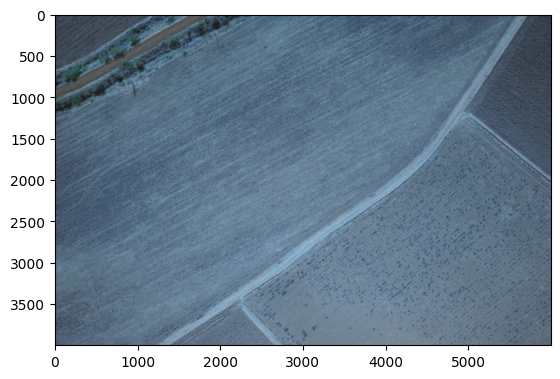

In [73]:
plt.imshow(img)

In [8]:
patch_height,patch_width,_ = img.shape
patch_height /= 10
patch_width /= 10
print(patch_height,patch_width)

400.0 600.0


In [10]:
cropped_image = img[0:int(patch_height), 0:int(patch_width)]

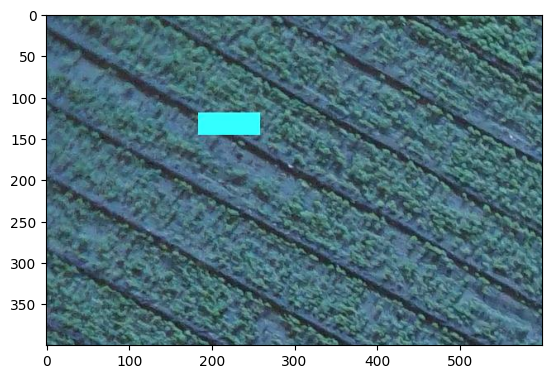

In [11]:
plt.imshow(cropped_image)

In [74]:
img_height, img_width, _ = img.shape

patch_height = 640
patch_width = 640

pad_top = 0
pad_bottom = patch_height - (img_height % patch_height)
pad_left = 0
pad_right = patch_width - (img_width % patch_width)

padded_img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

no_of_rows = padded_img.shape[0] // patch_height
no_of_columns = padded_img.shape[1] // patch_width

patches = []
for i in range(no_of_rows):
    for j in range(no_of_columns):
        top = i * patch_height
        bottom = (i + 1) * patch_height
        left = j * patch_width
        right = (j + 1) * patch_width
        cropped_image = padded_img[top:bottom, left:right]
        patches.append(cropped_image)


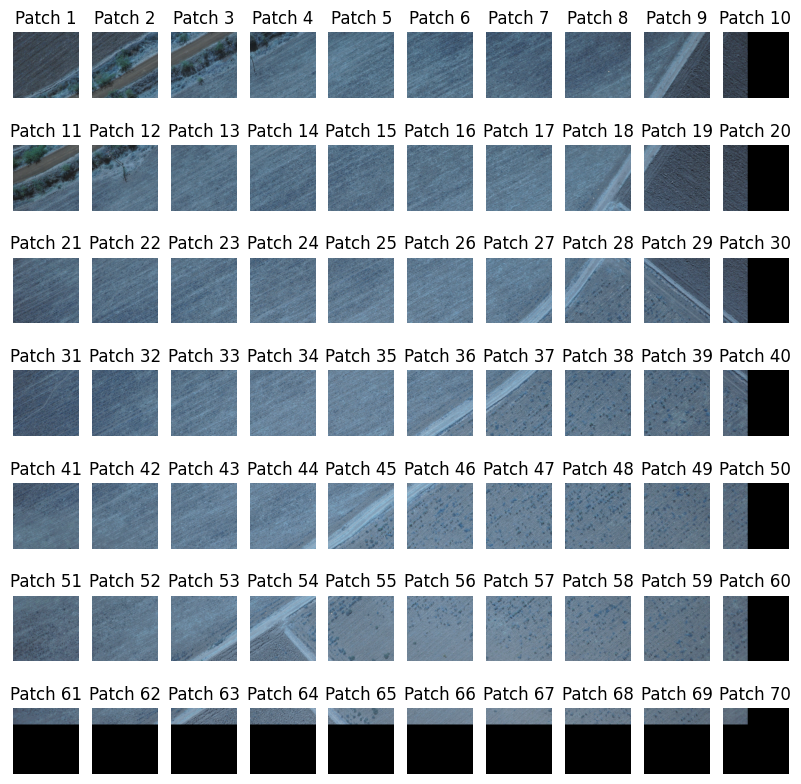

In [75]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(no_of_rows , no_of_columns, figsize = (10,10))

axes = axes.flatten()

for i, patch in enumerate(patches):
    axes[i].imshow(patch)
    axes[i].axis('off')
    axes[i].set_title(f'Patch {i+1}')



# plt.tight_layout()
plt.show()
# plt.savefig("patches.png")


In [2]:
import fiftyone as fo
dataset = fo.load_dataset("pipeline_data")

In [3]:
copy = dataset.clone()

In [4]:
session = fo.launch_app(copy)

(6000, 4000, 3)
(6400, 5120, 3)
Patch 9: Bounding Boxes [[2187.333333333333, 2610.0, 2425.9999999999995, 2883.0, 'TREES', 9.0]]
Patch 12: Bounding Boxes [[292.6666666666667, 3879.0, 582.6666666666667, 4209.0, 'TREES', 12.0], [1244.6666666666665, 4407.0, 1549.333333333333, 4696.5, 'TREES', 12.0]]
Patch 13: Bounding Boxes [[1915.3333333333333, 4483.5, 2182.6666666666665, 4755.0, 'TREES', 13.0]]


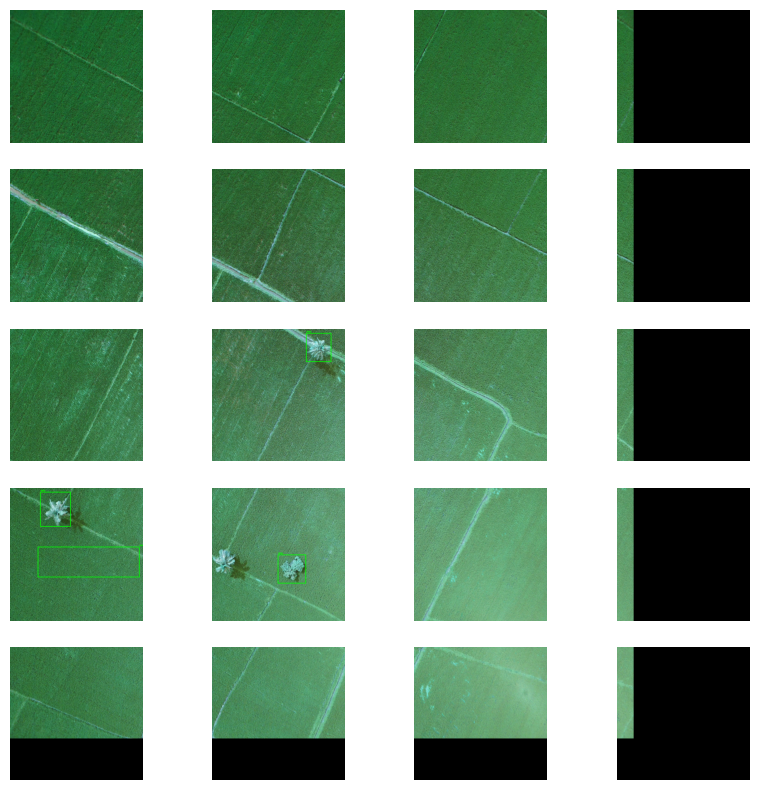

In [5]:
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def rearrange_bounding_boxes(bboxes, patch_height, patch_width, no_of_columns):
    rearranged_bboxes = []
    for bbox in bboxes:
        x, y, w, h, cls = bbox
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y + h
        # x3 = x + w
        # y3 = y + h
        # x4 = x
        # y4 = y + h

        patch_column = x1 // patch_width
        patch_row = y1 // patch_height
        patch_index = patch_row * no_of_columns + patch_column
        
        rearranged_bboxes.append([x1, y1, x2, y2, cls, patch_index])

    return rearranged_bboxes


def pad_image(img, patch_height, patch_width):
    img_height, img_width, _= img.shape
    pad_top = 0
    pad_bottom = patch_height - (img_height % patch_height)
    pad_left = 0
    pad_right = patch_width - (img_width % patch_width)
    padded_img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    return padded_img

def crop_patches(padded_img, patch_height, patch_width):
    no_of_rows = padded_img.shape[0] // patch_height
    no_of_columns = padded_img.shape[1] // patch_width
    patches = []
    for i in range(no_of_rows):
        for j in range(no_of_columns):
            top = i * patch_height
            bottom = (i + 1) * patch_height
            left = j * patch_width
            right = (j + 1) * patch_width
            cropped_image = padded_img[top:bottom, left:right]
            patches.append(cropped_image)
    return patches, no_of_rows, no_of_columns


def display_images_with_boxes(patches, rearranged_bounding_boxes, no_of_rows, no_of_columns):
    fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        patch_with_boxes = patches[i].copy()
        bounding_boxes = [bbox for bbox in rearranged_bounding_boxes if bbox[5] == i]
        
        if bounding_boxes:
            for bbox in bounding_boxes:
                x1, y1, x2, y2, cls, _ = bbox
           
                x_min = int(x1 % patch_width )
                y_min = int(y1 % patch_height )
                x_max = int(x2 % patch_width )
                y_max = int(y2 % patch_height )

                cv2.rectangle(patch_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)
                cv2.putText(patch_with_boxes, cls, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            ax.imshow(patch_with_boxes)
            ax.axis('off')

            print(f"Patch {i}: Bounding Boxes {bounding_boxes}")
        else:
            ax.imshow(patch_with_boxes)
            ax.axis('off')



patch_height = 1280
patch_width = 1280

samples = copy.take(1)

for sample in samples:
    img = cv2.imread(sample.filepath)
    img_width = img.shape[0]
    img_height = img.shape[1]
    print(img.shape)
    padded_img = pad_image(img, patch_height, patch_width)
    print(padded_img.shape)
    bboxes = []  
    for annotation in sample.ground_truth.detections:
        cls = annotation.label
        x, y, w, h = annotation.bounding_box[0]*img.shape[1], annotation.bounding_box[1]*img.shape[0], annotation.bounding_box[2]*img.shape[1], annotation.bounding_box[3]*img.shape[0]
        bboxes.append([x, y, w, h, cls])


    patches, no_of_rows, no_of_columns = crop_patches(padded_img, patch_height, patch_width)
    rearranged_bounding_boxes = rearrange_bounding_boxes(bboxes, patch_height, patch_width, no_of_columns)
    display_images_with_boxes(patches, rearranged_bounding_boxes, no_of_rows, no_of_columns)



In [46]:
samples = copy.take(1)

In [101]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


def rearrange_bounding_boxes(
    bboxes,
    patch_height,
    patch_width,
    no_of_columns,
    ):
    rearranged_bboxes = []
    for bbox in bboxes:
        (x, y, w, h, cls) = bbox
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y
        x3 = x + w
        y3 = y + h
        x4 = x
        y4 = y + h

        patch_column = x1 // patch_width
        patch_row = y1 // patch_height
        patch_index = patch_row * no_of_columns + patch_column

        rearranged_bboxes.append([
            x1,
            y1,
            x2,
            y2,
            x3,
            y3,
            x4,
            y4,
            cls,
            patch_index,
            ])

    return rearranged_bboxes


def display_images_with_boxes(
    patches,
    rearranged_bounding_boxes,
    no_of_rows,
    no_of_columns,
    patch_height,
    patch_width,
    ):

    for bbox in rearranged_bounding_boxes:
        occurance_matrix = np.zeros((no_of_rows, no_of_columns))

        (
            x1,
            y1,
            x2,
            y2,
            x3,
            y3,
            x4,
            y4,
            cls,
            patch_index,
            ) = bbox

        (stating_col, starting_row) = (int(x1 / patch_width), int(y1
                / patch_height))
        (stop_col, stop_row) = (int(x3 / patch_width), int(y3
                                / patch_height))

        for row in range(starting_row, stop_row + 1):
            for col in range(stating_col, stop_col + 1):
                occurance_matrix[row][col] = 1.0

        ppatch_width = no_of_columns * patch_width
        ppatch_height = no_of_rows * patch_height

        if np.sum(occurance_matrix) == 1:
            patch_with_boxes = patches[starting_row * no_of_columns
                    + stating_col]
            x1_patch = x1 % patch_width
            y1_patch = y1 % patch_height
            x2_patch = x2 % patch_width
            y2_patch = y2 % patch_height
            cv2.rectangle(patch_with_boxes, (int(x1_patch),
                          int(y1_patch)), (int(x2_patch),
                          int(y2_patch)), (0, 255, 0), 5)
            cv2.putText(
                patch_with_boxes,
                cls,
                (int(x1_patch), int(y1_patch) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2,
                )
        elif np.sum(occurance_matrix) == 2:

            if stating_col == stop_col:
                x1_patch = (x1 % patch_width if x1 > 0 else 0)
                y1_patch = (y1 % patch_height if y1 > 0 else 0)
            else:
                pass
        elif np.sum(occurance_matrix) == 4:
            pass

            # print(x1_patch,y1_patch,x2_patch,y2_patch)

    ax.imshow(patch_with_boxes)
    ax.axis('off')


                # print(f"Patch {i}: Bounding Boxes {bounding_boxes}")
        # else:
        #         ax.imshow(patch_with_boxes)
        #         ax.axis('off')

patch_height = 1280
patch_width = 1280

# samples = copy.take(1)

for sample in samples:
    img = cv2.imread(sample.filepath)
    img_width = img.shape[0]
    img_height = img.shape[1]
    print(img.shape)
    padded_img = pad_image(img, patch_height, patch_width)
    print(padded_img.shape)
    bboxes = []
    for annotation in sample.ground_truth.detections:
        cls = annotation.label
        (x, y, w, h) = (annotation.bounding_box[0] * img.shape[1],
                        annotation.bounding_box[1] * img.shape[0],
                        annotation.bounding_box[2] * img.shape[1],
                        annotation.bounding_box[3] * img.shape[0])
        bboxes.append([x, y, w, h, cls])

    (patches, no_of_rows, no_of_columns) = crop_patches(padded_img,
            patch_height, patch_width)
    rearranged_bounding_boxes = rearrange_bounding_boxes(bboxes,
            patch_height, patch_width, no_of_columns)
    display_images_with_boxes(
        patches,
        rearranged_bounding_boxes,
        no_of_rows,
        no_of_columns,
        patch_height,
        patch_width,
        )


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(img.shape)? (241608403.py, line 129)

In [49]:
1839/1280

1.43671875

In [29]:
3625//1280

2

In [119]:
samples = copy.take(1)

In [120]:

from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np


def pad_image(img, patch_height, patch_width):
    img_height, img_width, _= img.shape
    pad_top = 0
    pad_bottom = patch_height - (img_height % patch_height)
    pad_left = 0
    pad_right = patch_width - (img_width % patch_width)
    padded_img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    return padded_img

def crop_patches(padded_img, patch_height, patch_width):
    no_of_rows = padded_img.shape[0] // patch_height
    no_of_columns = padded_img.shape[1] // patch_width
    patches = []
    for i in range(no_of_rows):
        for j in range(no_of_columns):
            top = i * patch_height
            bottom = (i + 1) * patch_height
            left = j * patch_width
            right = (j + 1) * patch_width
            cropped_image = padded_img[top:bottom, left:right]
            patches.append(cropped_image)
    return patches, no_of_rows, no_of_columns

def rearrange_bounding_boxes(bboxes, patch_height, patch_width, no_of_columns):
    rearranged_bboxes = []
    for bbox in bboxes:
        x, y, w, h, cls = bbox
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y + h
        # x3 = x + w
        # y3 = y + h
        # x4 = x
        # y4 = y + h

        patch_column = x1 // patch_width
        patch_row = y1 // patch_height
        patch_index = patch_row * no_of_columns + patch_column
        
        rearranged_bboxes.append([x1, y1, x2, y2, cls, patch_index])

    return rearranged_bboxes

def display_images_with_boxes(patches, rearranged_bounding_boxes, no_of_rows, no_of_columns):
    fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        patch_with_boxes = patches[i].copy()
        bounding_boxes = [bbox for bbox in rearranged_bounding_boxes if bbox[5] == i]
        
        if bounding_boxes:
            # for bbox in bounding_boxes:
            #     x1, y1, x2, y2, cls, _ = bbox
           
            #     x_min = int(x1 % patch_width )
            #     y_min = int(y1 % patch_height )
            #     x_max = int(x2 % patch_width )
            #     y_max = int(y2 % patch_height )

                # cv2.rectangle(patch_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)
                # cv2.putText(patch_with_boxes, cls, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            ax.imshow(patch_with_boxes)
            ax.axis('off')

            print(f"Patch {i}: Bounding Boxes {bounding_boxes}")
        else:
            ax.imshow(patch_with_boxes)
            ax.axis('off')

(4000, 6000, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patch 0: Bounding Boxes [[354.6666666666667, 1083.0, 905.3333333333333, 1540.5, 'PERMENANT_STRUCTURES', 0.0]]
Patch 1: Bounding Boxes [[1316.0, 0.0, 1836.0, 510.00000000000006, 'PERMENANT_STRUCTURES', 1.0], [2129.3333333333335, 921.0, 2230.0, 1039.5, 'PERMENANT_STRUCTURES', 1.0], [2129.3333333333335, 921.0, 2230.0, 1039.5, 'PERMENANT_STRUCTURES', 1.0], [2129.3333333333335, 921.0, 2230.0, 1039.5, 'PERMENANT_STRUCTURES', 1.0], [2129.3333333333335, 921.0, 2230.0, 1039.5, 'PERMENANT_STRUCTURES', 1.0], [2129.3333333333335, 921.0, 2230.0, 1039.5, 'PERMENANT_STRUCTURES', 1.0], [2129.3333333333335, 921.0, 2230.0, 1039.5, 'PERMENANT_STRUCTURES', 1.0]]
Patch 4: Bounding Boxes [[534.0, 1974.0, 1049.3333333333333, 2472.0, 'PERMENANT_STRUCTURES', 4.0]]
Patch 5: Bounding Boxes [[1390.0, 2541.0, 1910.0, 3219.0, 'PERMENANT_STRUCTURES', 5.0], [1866.0, 1917.0, 2124.0, 2524.5, 'PERMENANT_STRUCTURES', 5.0], [1785.3333333333335, 2472.0, 1854.0000000000002, 2547.0, 'WELL', 5.0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patch 8: Bounding Boxes [[761.3333333333333, 3502.5, 1512.6666666666665, 3900.0, 'PERMENANT_STRUCTURES', 8.0], [851.3333333333334, 3255.0, 962.6666666666667, 3396.0, 'WELL', 8.0]]
Patch 9: Bounding Boxes [[1552.6666666666667, 3289.5, 1824.0, 3552.0, 'PERMENANT_STRUCTURES', 9.0]]


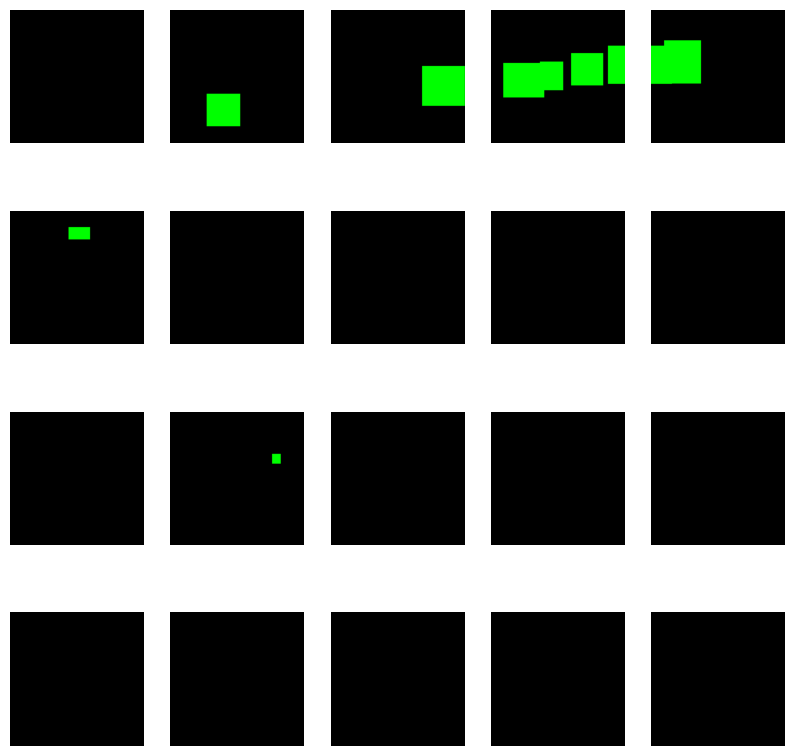

In [124]:
import matplotlib.pyplot as plt

patch_height = 1280
patch_width = 1280

for sample in samples:
    img = cv2.imread(sample.filepath)
    print(img.shape)
    empty_img = np.zeros(img.shape)

    

    for annotation in sample.ground_truth.detections:
        cls = annotation.label
        (x, y, w, h) = (annotation.bounding_box[0] * img.shape[1],
                        annotation.bounding_box[1] * img.shape[0],
                        annotation.bounding_box[2] * img.shape[1],
                        annotation.bounding_box[3] * img.shape[0])
        bboxes.append([x, y, w, h, cls])
    
        cv2.rectangle(empty_img, (int(x),int(y)),(int(x+w),int(y+h)), (0, 255, 0), -1)
        
    padded_img = pad_image(img, patch_height, patch_width)
    padded_empty_img = pad_image(empty_img, patch_height, patch_width)
    (patches, no_of_rows, no_of_columns) = crop_patches(padded_img,patch_height, patch_width)
    (empty_patches, no_of_rows, no_of_columns) = crop_patches(padded_empty_img,patch_height, patch_width)
    # rearranged_bounding_boxes = rearrange_bounding_boxes(bboxes, patch_height, patch_width, no_of_columns)
    display_images_with_boxes(empty_patches, rearranged_bounding_boxes, no_of_rows, no_of_columns)

    # plt.imshow(empty_img)
    # plt.show()
    # plt.imshow(img)
    # plt.show()

In [38]:
import fiftyone as fo
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import copy

patch_height = 1280
patch_width = 1280

def rect_to_bbox(patch):
    contours, _ = cv2.findContours(patch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        x, y, width, height = cv2.boundingRect(contours[0])
        return True, (x, y, width, height)
    return False, None

def pad_image(img, patch_height, patch_width):
    img_height, img_width, _ = img.shape
    pad_top = 0
    pad_bottom = patch_height - (img_height % patch_height)
    pad_left = 0
    pad_right = patch_width - (img_width % patch_width)
    padded_img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    return padded_img

def crop_patches(padded_img, patch_height, patch_width):
    no_of_rows = padded_img.shape[0] // patch_height
    no_of_columns = padded_img.shape[1] // patch_width
    patches = []
    for i in range(no_of_rows):
        for j in range(no_of_columns):
            top = i * patch_height
            bottom = (i + 1) * patch_height
            left = j * patch_width
            right = (j + 1) * patch_width
            cropped_image = padded_img[top:bottom, left:right]
            patches.append(cropped_image)
    return patches, no_of_rows, no_of_columns

def generate_patches_with_bboxes(image, bboxes):
    annotations = []
    image_patches, no_of_rows_image, no_of_columns_image = crop_patches(image, patch_height, patch_width)

    for bbox in bboxes:
        all_patches = []
        x, y, w, h, cls = bbox

        empty_img = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.rectangle(empty_img, (int(x), int(y)), (int(x + w), int(y + h)), (255, 255, 255), -1)
        black_patches, no_of_rows_black, no_of_columns_black = crop_patches(empty_img, patch_height, patch_width)
        for i, black_patch in enumerate(black_patches):
            flag, bbox = rect_to_bbox(black_patch)
            if flag:
                patch_bbox_info = {}
                patch_bbox_info['patch_id'] = i + len(all_patches)  
                patch_bbox_info['class'] = cls
                rect_x, rect_y, rect_w, rect_h = bbox
                patch_bbox_info['x'] = rect_x
                patch_bbox_info['y'] = rect_y
                patch_bbox_info['w'] = rect_w
                patch_bbox_info['h'] = rect_h
                all_patches.append(patch_bbox_info)
        annotations.append(all_patches)
    return image_patches, annotations, no_of_rows_image, no_of_columns_image


def display_on_patches(images_and_bboxes, output_directory):
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [] 
    }
    image_id = 0
    annotation_id = 0

    for cls_name, cls_idx in category_mapping.items():
            coco_format['categories'].append({
                "id": cls_idx,
                "name": cls_name,
            })

    for idx, (img, bboxes) in enumerate(images_and_bboxes):
        padded_img = pad_image(img, patch_height, patch_width)
        for bbox in bboxes:
            bbox[0] = bbox[0]*img.shape[1]
            bbox[1] = bbox[1]*img.shape[0]
            bbox[2] = bbox[2]*img.shape[1]
            bbox[3] = bbox[3]*img.shape[0]
        image_patches, annotations, no_of_rows_image, no_of_columns_image = generate_patches_with_bboxes(padded_img, bboxes)

        
        for i in range(len(image_patches)):
            patch = image_patches[i].copy()
            coco_format['images'].append({
                "id": image_id,
                "file_name": f"patch_{image_id}.jpg",
                "width": patch.shape[1],
                "height": patch.shape[0],
            })
            
            for object in annotations:
                for sub_obj in object:
                    if sub_obj['patch_id'] == i:
                        coco_format['annotations'].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "bbox": [sub_obj['x'], sub_obj['y'], sub_obj['w'], sub_obj['h']],
                            "category_id": category_mapping[sub_obj['class']], 
                        })
                        annotation_id += 1

            patch_path = os.path.join(output_directory, f"patch_{image_id}.jpg")
            cv2.imwrite(patch_path, patch)

            image_id += 1

    with open(os.path.join(output_directory, 'coco_format.json'), 'w') as f:
        json.dump(coco_format, f)

dataset = fo.load_dataset("pipeline_data")

copy = dataset.clone()

samples = copy.take(2)

category_mapping = {"TREES" : 0, "ELECTRIC_POLES" : 1, "PERMENANT_STRUCTURES" : 2, "TEMPORARY_STRUCTURES" : 3, "WELL" : 4, "PYLON" : 5,
                    "SOLAR" : 6, "TLP" : 7}

output_directory = "all_patches_data"
os.makedirs(output_directory, exist_ok=True)

display_on_patches([(cv2.imread(sample.filepath), 
                     [[annotation.bounding_box[0],
                       annotation.bounding_box[1],
                       annotation.bounding_box[2],
                       annotation.bounding_box[3],
                       annotation.label] for annotation in sample.ground_truth.detections]) for sample in samples],
                    output_directory)


In [46]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import uuid

patch_height = 1280
patch_width = 1280

def rect_to_bbox(patch):
    contours, _ = cv2.findContours(patch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        x, y, width, height = cv2.boundingRect(contours[0])
        return True,(x, y, width, height)
    return False,None

def pad_image(img, patch_height, patch_width):
    img_height, img_width, _= img.shape
    pad_top = 0
    pad_bottom = patch_height - (img_height % patch_height)
    pad_left = 0
    pad_right = patch_width - (img_width % patch_width)
    padded_img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    return padded_img
    
def crop_patches(padded_img, patch_height, patch_width):
    no_of_rows = padded_img.shape[0] // patch_height
    no_of_columns = padded_img.shape[1] // patch_width
    patches = []
    for i in range(no_of_rows):
        for j in range(no_of_columns):
            top = i * patch_height
            bottom = (i + 1) * patch_height
            left = j * patch_width
            right = (j + 1) * patch_width
            cropped_image = padded_img[top:bottom, left:right]
            patches.append(cropped_image)
    return patches, no_of_rows, no_of_columns
    
def generate_patches_with_bboxes(image,bboxes):
    annotations = []
    image_patches,no_of_rows_image, no_of_columns_image = crop_patches(image,patch_height,patch_width)
    
    for bbox in bboxes:
        all_patches = []
        x, y, w, h, cls = bbox
       
        empty_img =  np.zeros(image.shape[:2], dtype=np.uint8) 
        cv2.rectangle(empty_img, (int(x),int(y)),(int(x+w),int(y+h)), (255,255, 255), -1)
        black_patches,no_of_rows_black, no_of_columns_black = crop_patches(empty_img,patch_height,patch_width)
        for i,black_patch in enumerate(black_patches):
            flag,bbox = rect_to_bbox(black_patch)
            if flag:
                patch_bbox_info = {}
                patch_bbox_info['patch_id'] = i
                patch_bbox_info['class'] = cls
                rect_x,rect_y,rect_w,rect_h = bbox
                patch_bbox_info['x'] = rect_x
                patch_bbox_info['y'] = rect_y
                patch_bbox_info['w'] = rect_w
                patch_bbox_info['h'] = rect_h
                all_patches.append(patch_bbox_info)
        annotations.append(all_patches)
    return image_patches,annotations, no_of_rows_image, no_of_columns_image



def display_on_patches(image_patches,annotations):
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [] 
    }
    image_id = 0
    annotation_id = 0

    for cls_name, cls_idx in category_mapping.items():
            coco_format['categories'].append({
                "id": cls_idx,
                "name": cls_name,
            })

    for i in range(len(image_patches)):
        patch = image_patches[i].copy()
        coco_format['images'].append({
                "id": image_id,
                "file_name": f"patch_{image_id}.jpg",
                "width": patch.shape[1],
                "height": patch.shape[0],
            })
        for object in annotations:
            for sub_obj in object:
                if sub_obj['patch_id'] == i:
                    x,y,w,h,cls = sub_obj['x'],sub_obj['y'],sub_obj['w'],sub_obj['h'],sub_obj['class']
                    coco_format['annotations'].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "bbox": [x,y,w,h],
                            "category_id": category_mapping[sub_obj['class']]
                    })
                    annotation_id += 1
                    
        patch_path = os.path.join(output_directory, f"patch_{image_id}.jpg")
        cv2.imwrite(patch_path, patch)    

        image_id += 1

    with open(os.path.join(output_directory, 'coco_format.json'), 'w') as f:
        json.dump(coco_format, f)

dataset = fo.load_dataset("pipeline_data")

copy = dataset.clone()

samples = copy.take(50)

# category_mapping = {"TREES" : 0, "ELECTRIC_POLES" : 1, "PERMENANT_STRUCTURES" : 2, "TEMPORARY_STRUCTURES" : 3, "WELL" : 4, "PYLON" : 5,
#                     "SOLAR" : 6, "TLP" : 7}

output_directory = "all_patches_data"
os.makedirs(output_directory, exist_ok=True)
image_id = 0
annotation_id = 0

category_data = [{"id":0, "name":"TREES","supercategory":None},{"id":1, "name":"ELECTRIC_POLES","supercategory":None},
                 {"id":2, "name":"PERMENANT_STRUCTURES","supercategory":None},{"id":3, "name":"TEMPORARY_STRUCTURES","supercategory":None},
                 {"id":4, "name":"WELL","supercategory":None},{"id":5, "name":"PYLON","supercategory":None},
                 {"id":6, "name":"SOLAR","supercategory":None},{"id":7, "name":"TLP","supercategory":None}]
image_data = []
annotations_data = []

with fo.ProgressBar() as pb:

    for sample in samples:
        img = cv2.imread(sample.filepath)
        
        padded_img = pad_image(img, patch_height, patch_width)
        
        bboxes = []
        for annotation in sample.ground_truth.detections:
            cls = annotation.label
            (x, y, w, h) = (annotation.bounding_box[0] * img.shape[1],
                            annotation.bounding_box[1] * img.shape[0],
                            annotation.bounding_box[2] * img.shape[1],
                            annotation.bounding_box[3] * img.shape[0])
            bboxes.append([x, y, w, h, cls])
        image_patches,annotations,no_of_rows_image,no_of_columns_image = generate_patches_with_bboxes(padded_img,bboxes)
    
        for i,patch in enumerate(image_patches):
            filename = f"{uuid.uuid4()}.jpg"
            patch_path = os.path.join(output_directory, filename)
            cv2.imwrite(patch_path,patch)
            patch_data = {
                "id": image_id,
                "file_name": filename,
                "width": patch.shape[1],
                "height": patch.shape[0],
            }
            image_data.append(patch_data)
            
    
            for annotation in annotations:
                for sub_obj in annotation:
                    if sub_obj["patch_id"] == i:
                        x,y,w,h,cls = sub_obj['x'],sub_obj['y'],sub_obj['w'],sub_obj['h'],sub_obj['class']
                        for category in category_data:
                            if cls == category["name"]:
                                class_id = category["id"]
                        annotation_data = {"id": annotation_id,
                                           "image_id": image_id,
                                           "category_id": class_id,
                                           "bbox": [x,y,w,h],
                                           "score": 1.0,
                                           "area": w*h,
                                           "iscrowd": 0
                                          }
                        annotations_data.append(annotation_data)
                        annotation_id += 1
                        
            image_id += 1


coco_format = {
        "images": image_data,
        "annotations": annotations_data,
        "categories": category_data
    }

with open(('coco_format.json'), 'w') as f:
        json.dump(coco_format, f)



 0 [28.0s elapsed, ? remaining, ? samples/s] 


[[{'patch_id': 14, 'class': 'TREES', 'x': 810, 'y': 991, 'w': 182, 'h': 147}], [{'patch_id': 14, 'class': 'TREES', 'x': 608, 'y': 615, 'w': 313, 'h': 325}], [{'patch_id': 14, 'class': 'TREES', 'x': 1109, 'y': 889, 'w': 171, 'h': 168}, {'patch_id': 15, 'class': 'TREES', 'x': 0, 'y': 889, 'w': 17, 'h': 168}], [{'patch_id': 13, 'class': 'TREES', 'x': 1237, 'y': 658, 'w': 43, 'h': 232}, {'patch_id': 14, 'class': 'TREES', 'x': 0, 'y': 658, 'w': 266, 'h': 232}], [{'patch_id': 13, 'class': 'TREES', 'x': 1140, 'y': 958, 'w': 17, 'h': 10}], [{'patch_id': 13, 'class': 'TREES', 'x': 808, 'y': 418, 'w': 224, 'h': 337}], [{'patch_id': 13, 'class': 'TREES', 'x': 463, 'y': 240, 'w': 407, 'h': 568}], [{'patch_id': 12, 'class': 'TREES', 'x': 1266, 'y': 150, 'w': 14, 'h': 289}, {'patch_id': 13, 'class': 'TREES', 'x': 0, 'y': 150, 'w': 264, 'h': 289}], [{'patch_id': 9, 'class': 'TREES', 'x': 48, 'y': 1268, 'w': 167, 'h': 12}, {'patch_id': 13, 'class': 'TREES', 'x': 48, 'y': 0, 'w': 167, 'h': 137}], [{'pa

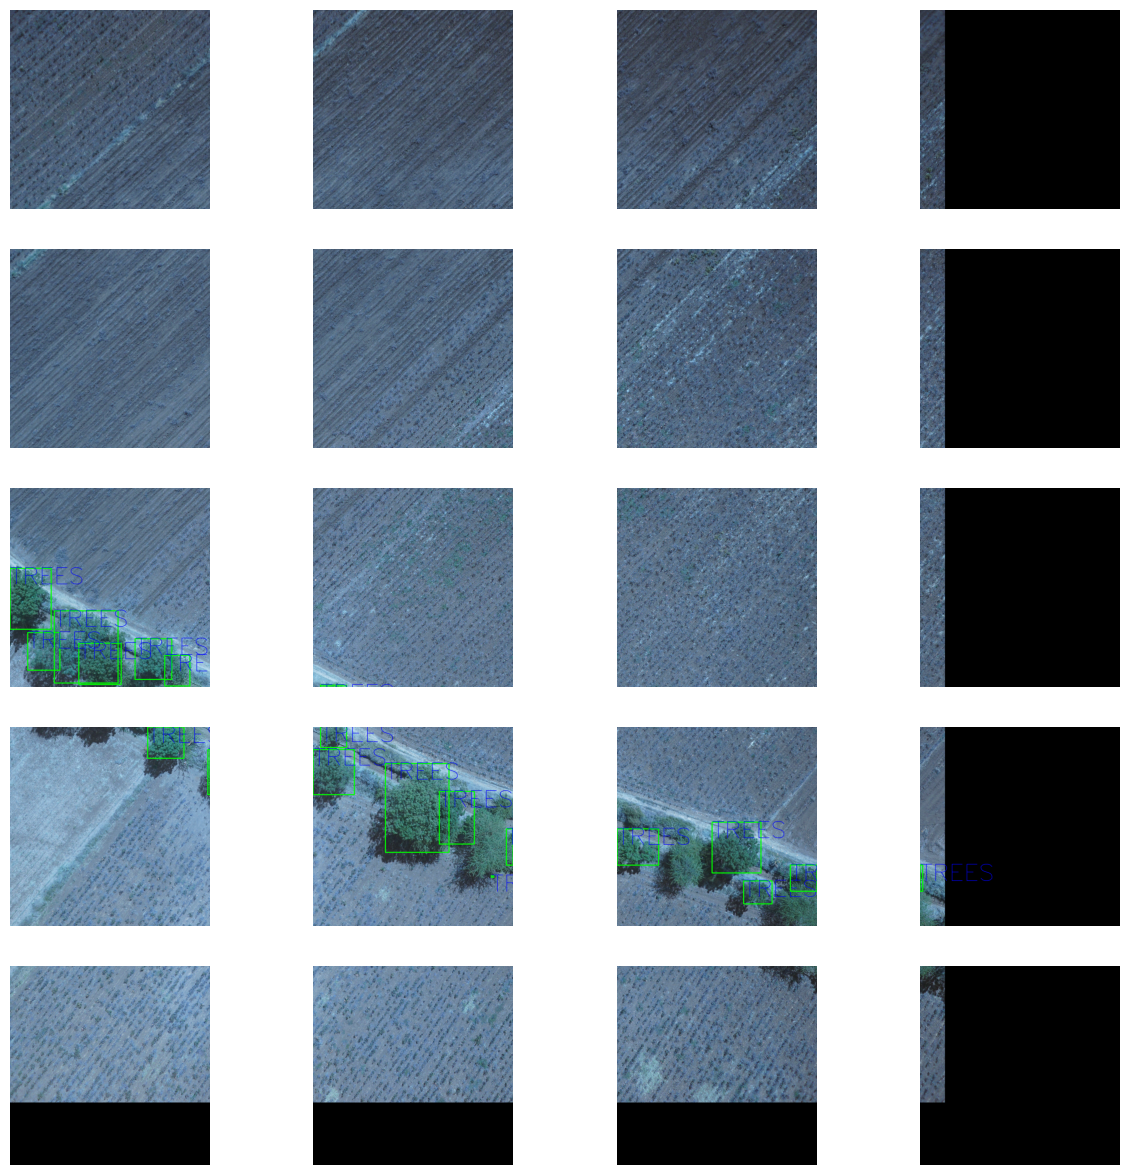

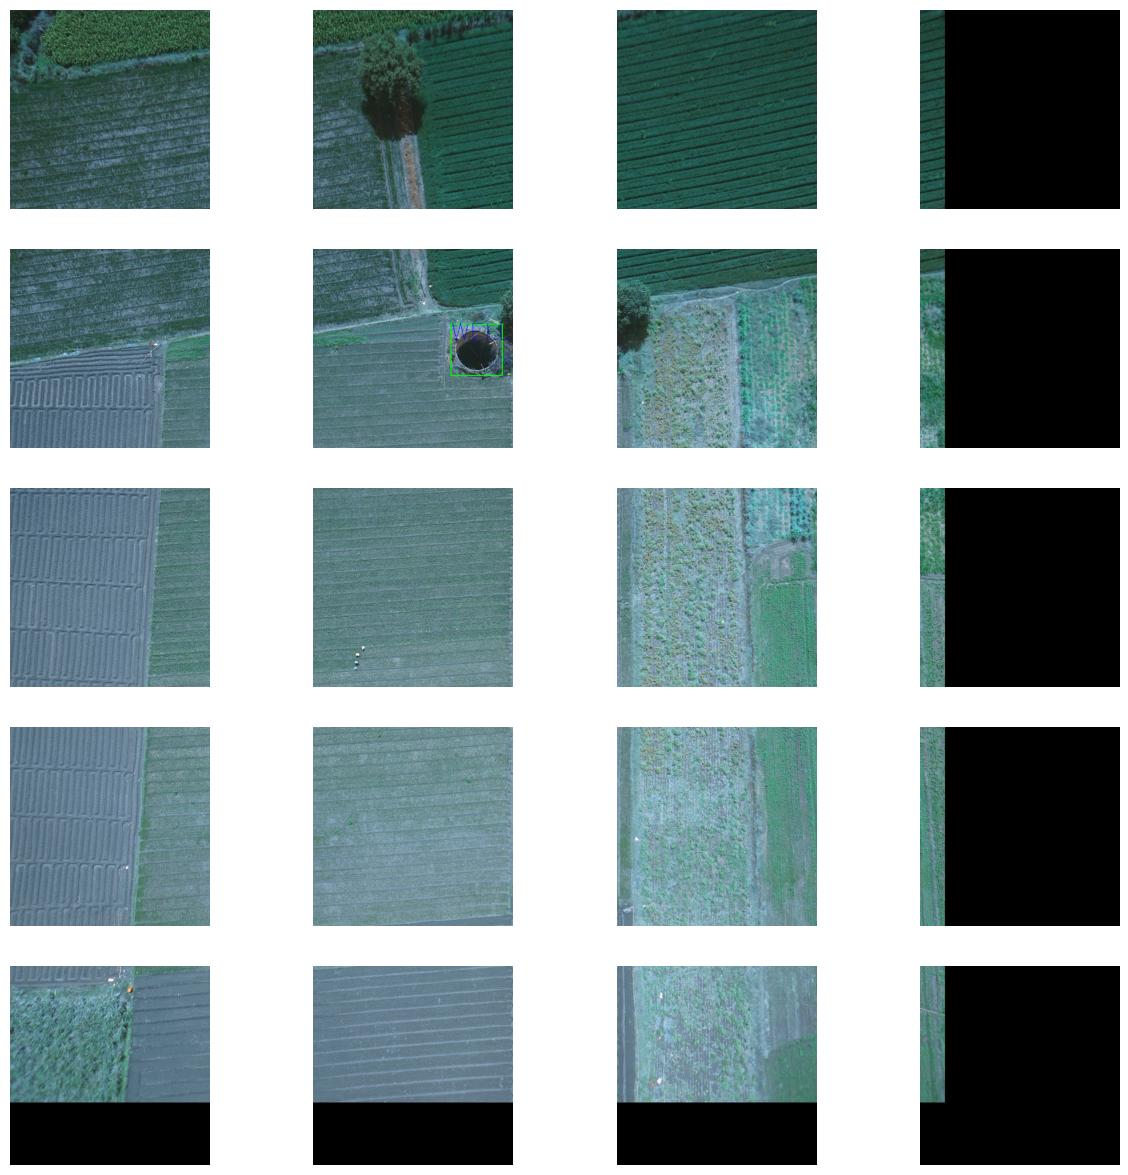

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

patch_height = 1280
patch_width = 1280

def rect_to_bbox(patch):
    contours, _ = cv2.findContours(patch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        x, y, width, height = cv2.boundingRect(contours[0])
        return True,(x, y, width, height)
    return False,None

def pad_image(img, patch_height, patch_width):
    img_height, img_width, _= img.shape
    pad_top = 0
    pad_bottom = patch_height - (img_height % patch_height)
    pad_left = 0
    pad_right = patch_width - (img_width % patch_width)
    padded_img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    return padded_img
    
def crop_patches(padded_img, patch_height, patch_width):
    no_of_rows = padded_img.shape[0] // patch_height
    no_of_columns = padded_img.shape[1] // patch_width
    patches = []
    for i in range(no_of_rows):
        for j in range(no_of_columns):
            top = i * patch_height
            bottom = (i + 1) * patch_height
            left = j * patch_width
            right = (j + 1) * patch_width
            cropped_image = padded_img[top:bottom, left:right]
            patches.append(cropped_image)
    return patches, no_of_rows, no_of_columns
    
def generate_patches_with_bboxes(image,bboxes):
    annotations = []
    image_patches,no_of_rows_image, no_of_columns_image = crop_patches(image,patch_height,patch_width)
    
    for bbox in bboxes:
        all_patches = []
        x, y, w, h, cls = bbox
       
        empty_img =  np.zeros(image.shape[:2], dtype=np.uint8) 
        cv2.rectangle(empty_img, (int(x),int(y)),(int(x+w),int(y+h)), (255,255, 255), -1)
        black_patches,no_of_rows_black, no_of_columns_black = crop_patches(empty_img,patch_height,patch_width)
        for i,black_patch in enumerate(black_patches):
            flag,bbox = rect_to_bbox(black_patch)
            if flag:
                patch_bbox_info = {}
                patch_bbox_info['patch_id'] = i
                patch_bbox_info['class'] = cls
                rect_x,rect_y,rect_w,rect_h = bbox
                patch_bbox_info['x'] = rect_x
                patch_bbox_info['y'] = rect_y
                patch_bbox_info['w'] = rect_w
                patch_bbox_info['h'] = rect_h
                all_patches.append(patch_bbox_info)
        annotations.append(all_patches)
    return image_patches,annotations,no_of_rows_image,no_of_columns_image

def display_on_patches(image_patches,annotations,no_of_rows,no_of_columns):
    fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(15, 15))
    print(annotations)
    for i, ax in enumerate(axes.flat):
        patch = image_patches[i].copy()
        for object in annotations:
            for sub_obj in object:
                if sub_obj['patch_id'] == i:
                    x,y,w,h,cls = sub_obj['x'],sub_obj['y'],sub_obj['w'],sub_obj['h'],sub_obj['class']
                    cv2.rectangle(patch, (int(x),int(y)),(int(x+w),int(y+h)), (0,255, 0), 5)
                    cv2.putText(patch,cls,(int(x),int(y+100)),cv2.FONT_HERSHEY_SIMPLEX,5,(0,0,255),2,cv2.LINE_AA)
        ax.imshow(patch)
        ax.axis('off')

# dataset = fo.load_dataset("pipeline_data")

# copy = dataset.clone()

# samples = copy.take(2)

for sample in samples:
    img = cv2.imread(sample.filepath)
    
    padded_img = pad_image(img, patch_height, patch_width)
    bboxes = []
    for annotation in sample.ground_truth.detections:
        cls = annotation.label
        (x, y, w, h) = (annotation.bounding_box[0] * img.shape[1],
                        annotation.bounding_box[1] * img.shape[0],
                        annotation.bounding_box[2] * img.shape[1],
                        annotation.bounding_box[3] * img.shape[0])
        bboxes.append([x, y, w, h, cls])
    image_patches,annotations,no_of_rows_image,no_of_columns_image = generate_patches_with_bboxes(padded_img,bboxes)
    # save_patches_in_coco_format(image_patches, annotations, output_directory)

    display_on_patches(image_patches,annotations,no_of_rows_image,no_of_columns_image)
    # plt.imshow(padded_img)